In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

#1. Параметры

In [74]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 50

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


#2. Загрузка и предобработка данных

In [75]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка обучающего набора
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Загрузка тестового набора
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Классы
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Данные загружены.")

print(f"Размер обучающей выборки (X): {train_loader.dataset.data.shape}")
print(f"Размер обучающей выборки (y): ({len(train_loader.dataset.targets)})")
print(f"Размер тестовой выборки (X): {test_loader.dataset.data.shape}")
print(f"Размер тестовой выборки (y): ({len(test_loader.dataset.targets)})")

Данные загружены.
Размер обучающей выборки (X): (50000, 32, 32, 3)
Размер обучающей выборки (y): (50000)
Размер тестовой выборки (X): (10000, 32, 32, 3)
Размер тестовой выборки (y): (10000)


#3. Примеры изображений

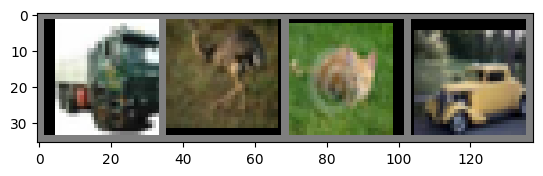

Метки:  truck bird  cat   car  


In [76]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print('Метки: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#4. Реализация нейронной сети

In [77]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.block7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.maxpool_final = nn.MaxPool2d(kernel_size=4, stride=4)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.maxpool_final(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)

print("Архитектура модели:")
print(model)

Архитектура модели:
SimpleCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

#5. Функция потерь и оптимизатор

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

#6. Обучение модели

In [79]:
train_losses = []
test_losses = []

early_stopper = EarlyStopper(patience=7, min_delta=0.01)

for epoch in range(EPOCHS):
    start_time = time.time()

    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # Прямое распространение
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        # Сбор статистики
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Расчет ошибки
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)

    model.eval()
    current_test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()

    epoch_test_loss = current_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    model.train()

    print(f"Эпоха [{epoch+1}/{EPOCHS}] | "
          f"Время: {epoch_duration:.2f} с | "
          f"Ошибка (Train): {epoch_loss:.4f} | "
          f"Точность (Train): {epoch_accuracy:.2f}% | "
          f"Ошибка (Test): {epoch_test_loss:.4f}")

    if early_stopper.early_stop(epoch_test_loss):
        print(f"Ранняя остановка")
        break

Эпоха [1/50] | Время: 21.36 с | Ошибка (Train): 1.3055 | Точность (Train): 52.69% | Ошибка (Test): 1.3583
Эпоха [2/50] | Время: 21.51 с | Ошибка (Train): 0.9100 | Точность (Train): 68.10% | Ошибка (Test): 1.8478
Эпоха [3/50] | Время: 20.41 с | Ошибка (Train): 0.7796 | Точность (Train): 72.89% | Ошибка (Test): 0.9768
Эпоха [4/50] | Время: 20.86 с | Ошибка (Train): 0.7002 | Точность (Train): 75.87% | Ошибка (Test): 0.7012
Эпоха [5/50] | Время: 21.10 с | Ошибка (Train): 0.6333 | Точность (Train): 78.28% | Ошибка (Test): 0.7585
Эпоха [6/50] | Время: 21.67 с | Ошибка (Train): 0.5844 | Точность (Train): 79.86% | Ошибка (Test): 0.6632
Эпоха [7/50] | Время: 21.54 с | Ошибка (Train): 0.5364 | Точность (Train): 81.66% | Ошибка (Test): 0.5335
Эпоха [8/50] | Время: 21.72 с | Ошибка (Train): 0.5089 | Точность (Train): 82.50% | Ошибка (Test): 0.5497
Эпоха [9/50] | Время: 21.86 с | Ошибка (Train): 0.4847 | Точность (Train): 83.46% | Ошибка (Test): 0.5801
Эпоха [10/50] | Время: 21.89 с | Ошибка (Train

#7. Оценка на тестовом наборе

In [80]:
model.eval()

correct_test = 0
total_test = 0
test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Расчет ошибки и точности на тестовом наборе
final_test_loss = test_loss / len(test_loader)
final_test_accuracy = 100 * correct_test / total_test

print(f"Ошибка классификации (Test): {final_test_loss:.4f}")
print(f"Точность классификации (Test): {final_test_accuracy:.2f}%")

Ошибка классификации (Test): 0.4437
Точность классификации (Test): 85.52%


#8. График ошибки обучения

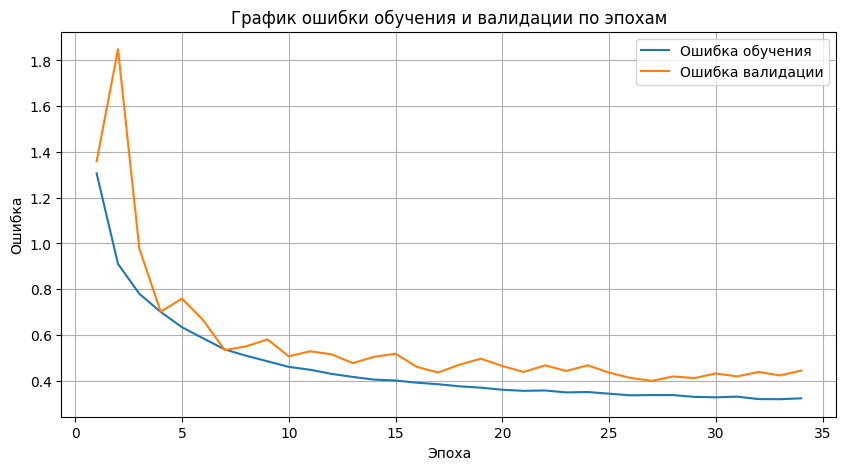

In [81]:
final_epochs = len(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, final_epochs + 1), train_losses, label='Ошибка обучения')
plt.plot(range(1, final_epochs + 1), test_losses, label='Ошибка валидации')
plt.title('График ошибки обучения и валидации по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True)
plt.show()